In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import sqlite3
from datetime import timedelta

sns.set(style="whitegrid", rc={"figure.figsize": (10, 5)})
np.random.seed(42)

In [27]:
# параметры "приложения/магазина"
n_users = 25000
start = pd.Timestamp("2024-07-01")
days = 30

# пользователи
users = pd.DataFrame({
    "user_id": np.arange(1, n_users + 1),
    "signup_dt": start + pd.to_timedelta(np.random.randint(0, days, n_users), unit="D"),
    "country": np.random.choice(["RU", "US", "DE", "IN"], size=n_users, p=[0.4, 0.3, 0.2, 0.1]),
    "device": np.random.choice(["ios", "android", "web"], size=n_users, p=[0.35, 0.45, 0.20]),
    "channel": np.random.choice(["ads", "organic", "referral"], size=n_users, p=[0.5, 0.4, 0.1]),
    "exp_group": np.random.choice(["A", "B"], size=n_users, p=[0.5, 0.5]),
})

# события: воронка view -> cart -> purchase
events = []
eid = 1
for row in users.itertuples(index=False):
    sessions = np.random.poisson(2) + 1
    for s in range(sessions):
        ts = row.signup_dt + timedelta(days=int(np.random.randint(0, days)),
                                       minutes=int(np.random.randint(0, 24*60)))
        if row.exp_group == "A":
            p_view, p_cart, p_buy = 0.78, 0.30, 0.36
        else:
            p_view, p_cart, p_buy = 0.81, 0.32, 0.40
        if np.random.rand() < p_view:
            events.append((eid, row.user_id, ts, "view", None)); eid += 1
            if np.random.rand() < p_cart:
                events.append((eid, row.user_id, ts + timedelta(minutes=np.random.randint(1, 60)), "cart", None)); eid += 1
                if np.random.rand() < p_buy:
                    amount = max(5, np.random.normal(50, 15))
                    events.append((eid, row.user_id, ts + timedelta(minutes=np.random.randint(2, 120)), "purchase", round(float(amount), 2))); eid += 1

events = pd.DataFrame(events, columns=["event_id", "user_id", "ts", "event_type", "amount"]).sort_values("ts").reset_index(drop=True)
from IPython.display import display
display(users.head())
display(events.head())
print(f"users: {users.shape}, events: {events.shape}")

,user_id,signup_dt,country,device,channel,exp_group
0,1,2024-07-12,IN,android,ads,A
1,2,2024-07-28,DE,web,ads,A
2,3,2024-07-30,US,android,organic,B
3,4,2024-07-01,US,android,organic,A
4,5,2024-07-04,IN,android,ads,B


,event_id,user_id,ts,event_type,amount
0,72368,21257,2024-07-01 00:29:00,view,NaN
1,16473,4862,2024-07-01 00:34:00,view,NaN
2,60881,17856,2024-07-01 00:48:00,view,NaN
3,72369,21257,2024-07-01 00:54:00,cart,NaN
4,33167,9783,2024-07-01 01:02:00,view,NaN


users: (25000, 6), events: (85246, 5)


In [18]:
conn = sqlite3.connect("ab_shop.db")
users.to_sql("users", conn, index=False, if_exists="replace")
events.to_sql("events", conn, index=False, if_exists="replace")
conn.execute("CREATE INDEX IF NOT EXISTS idx_events_user ON events(user_id);")
conn.execute("CREATE INDEX IF NOT EXISTS idx_events_type ON events(event_type);")
conn.commit()

print("Готово. Таблицы в SQLite пересозданы.")
display(users.head())
display(events.head())

Готово. Таблицы в SQLite пересозданы.


,user_id,signup_dt,country,device,channel,exp_group
0,1,2024-07-07,RU,android,ads,B
1,2,2024-07-20,RU,web,referral,B
2,3,2024-07-29,US,android,ads,A
3,4,2024-07-15,RU,ios,ads,A
4,5,2024-07-11,US,web,organic,B


,event_id,user_id,ts,event_type,amount
0,67398,19937,2024-07-01 00:10:00,view,NaN
1,24273,7163,2024-07-01 00:13:00,view,NaN
2,28587,8513,2024-07-01 02:04:00,view,NaN
3,74556,22005,2024-07-01 02:09:00,view,NaN
4,26283,7787,2024-07-01 02:10:00,view,NaN


In [20]:
# размер групп
q_groups = """
SELECT exp_group, COUNT(*) AS users
FROM users
GROUP BY exp_group;
"""
groups = pd.read_sql(q_groups, conn)
display(groups)

# воронка по событиям
q_funnel = """
SELECT u.exp_group,
       SUM(CASE WHEN e.event_type='view' THEN 1 ELSE 0 END) AS views,
       SUM(CASE WHEN e.event_type='cart' THEN 1 ELSE 0 END) AS carts,
       SUM(CASE WHEN e.event_type='purchase' THEN 1 ELSE 0 END) AS purchases
FROM users u JOIN events e ON u.user_id = e.user_id
GROUP BY u.exp_group;
"""
funnel = pd.read_sql(q_funnel, conn)
display(funnel)

# конверсия в покупку (по пользователям)
q_conv = """
WITH buyers AS (SELECT DISTINCT user_id FROM events WHERE event_type='purchase')
SELECT u.exp_group,
       COUNT(DISTINCT u.user_id) AS users,
       COUNT(DISTINCT CASE WHEN b.user_id IS NOT NULL THEN u.user_id END) AS buyers
FROM users u
LEFT JOIN buyers b ON u.user_id = b.user_id
GROUP BY u.exp_group;
"""
conv = pd.read_sql(q_conv, conn)
conv["cr"] = conv["buyers"] / conv["users"]
display(conv)

# доход по группам
q_rev = """
SELECT u.exp_group,
       SUM(CASE WHEN e.event_type='purchase' THEN e.amount ELSE 0 END) AS revenue,
       COUNT(DISTINCT u.user_id) AS users
FROM users u
LEFT JOIN events e ON u.user_id = e.user_id
GROUP BY u.exp_group;
"""
rev = pd.read_sql(q_rev, conn)
rev["ARPU"] = rev["revenue"] / rev["users"]
display(rev)

,exp_group,users
0,A,12476
1,B,12524


,exp_group,views,carts,purchases
0,A,29273,8873,3251
1,B,30066,9493,3839


,exp_group,users,buyers,cr
0,A,12476,2870,0.230042
1,B,12524,3381,0.269962


,exp_group,revenue,users,ARPU
0,A,160819.15,12476,12.890281
1,B,192820.25,12524,15.396060


In [21]:
hypo = pd.DataFrame([
    ["Новый чек-аут уменьшает трение на оплате",            8, 7, 7, 4],
    ["Бесплатная доставка от $60 повышает AOV",             6, 6, 6, 5],
    ["Баннер с топ-товарами на главной",                    7, 4, 6, 3],
    ["Ускорение загрузки каталога на 20%",                  9, 5, 6, 6],
    ["Поиск по фото",                                       3, 7, 5, 8],
    ["-10% новичкам 3 дня после установки",                 5, 6, 5, 4],
], columns=["hypothesis", "reach", "impact", "confidence", "effort"])
hypo["ICE"] = (hypo["impact"]*hypo["confidence"]) / hypo["effort"]
hypo["RICE"] = (hypo["reach"]*hypo["impact"]*hypo["confidence"]) / hypo["effort"]
display(hypo.sort_values("RICE", ascending=False))

,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,Новый чек-аут уменьшает трение на оплате,8,7,7,4,12.250,98.000
2,Баннер с топ-товарами на главной,7,4,6,3,8.000,56.000
3,Ускорение загрузки каталога на 20%,9,5,6,6,5.000,45.000
1,Бесплатная доставка от $60 повышает AOV,6,6,6,5,7.200,43.200
5,-10% новичкам 3 дня после установки,5,6,5,4,7.500,37.500
4,Поиск по фото,3,7,5,8,4.375,13.125


users NA:
 user_id      0
signup_dt    0
country      0
device       0
channel      0
exp_group    0
dtype: int64 

events NA:
 event_id          0
user_id           0
ts                0
event_type        0
amount        77705
date              0
dtype: int64 

Duplicates in events: 0


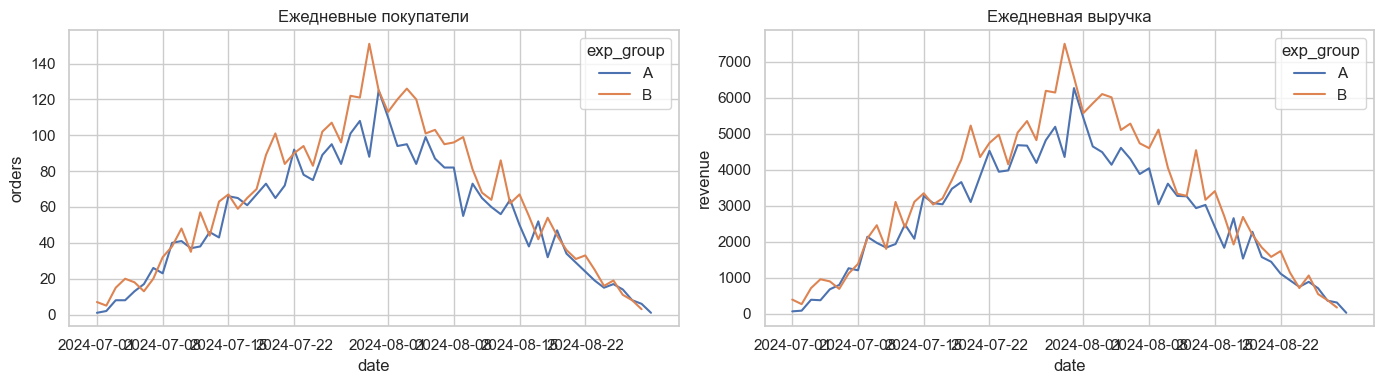

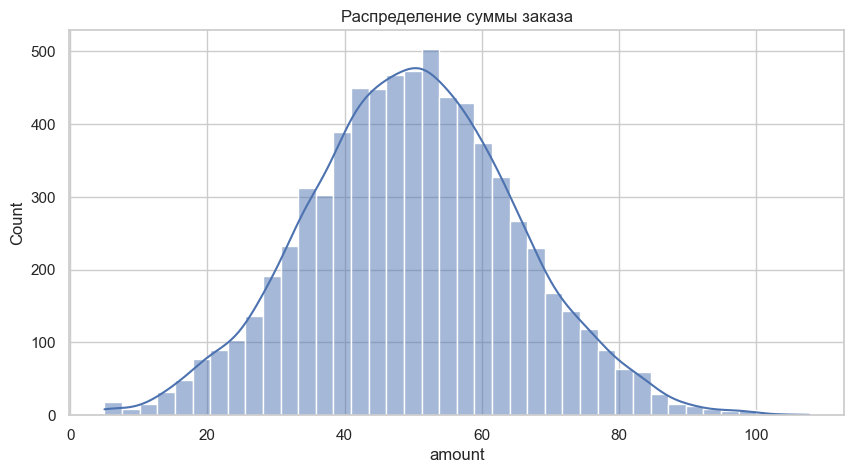

In [23]:
print("users NA:\n", users.isna().sum(), "\n")
print("events NA:\n", events.isna().sum(), "\n")
print("Duplicates in events:", events.duplicated(subset=["event_id"]).sum())

# ежедневные покупки и выручка по группам
events["date"] = pd.to_datetime(events["ts"]).dt.date
purchases = events[events.event_type=="purchase"].merge(users[["user_id","exp_group"]], on="user_id")
daily = purchases.groupby(["date","exp_group"]).agg(orders=("user_id","nunique"),
                                                    revenue=("amount","sum")).reset_index()

fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.lineplot(data=daily, x="date", y="orders", hue="exp_group", ax=ax[0])
ax[0].set_title("Ежедневные покупатели")
sns.lineplot(data=daily, x="date", y="revenue", hue="exp_group", ax=ax[1])
ax[1].set_title("Ежедневная выручка")
plt.tight_layout(); plt.show()

sns.histplot(purchases["amount"], bins=40, kde=True)
plt.title("Распределение суммы заказа"); plt.show()

In [24]:
# фильтруем 1% самых больших чеков
p99 = purchases["amount"].quantile(0.99)
purchases_f = purchases[purchases["amount"] <= p99].copy()

# флаг покупателя и выручка на пользователя
buyers_flag = purchases_f.groupby("user_id").size().rename("is_buyer").reset_index()
buyers_flag["is_buyer"] = 1
user_level = users.merge(buyers_flag, on="user_id", how="left").fillna({"is_buyer":0})

revenue_per_user = purchases_f.groupby("user_id")["amount"].sum().rename("revenue").reset_index()
user_level = user_level.merge(revenue_per_user, on="user_id", how="left").fillna({"revenue":0.0})

display(user_level.groupby("exp_group").agg(users=("user_id","count"),
                                            buyers=("is_buyer","sum"),
                                            cr=("is_buyer","mean"),
                                            ARPU=("revenue","mean")).reset_index())

,exp_group,users,buyers,cr,ARPU
0,A,12476,2844.0,0.227958,12.649437
1,B,12524,3352.0,0.267646,15.118868


In [25]:
alpha = 0.05

# конверсия (z-test для долей)
succ = user_level.groupby("exp_group")["is_buyer"].sum().reindex(["A","B"]).values
tot  = user_level.groupby("exp_group")["is_buyer"].count().reindex(["A","B"]).values
z_stat, p_val = proportions_ztest(succ, tot, alternative="two-sided")

cr_a, cr_b = succ[0]/tot[0], succ[1]/tot[1]
lift_cr = (cr_b/cr_a - 1) * 100

print(f"Conversion A: {cr_a:.4f}, B: {cr_b:.4f}, lift: {lift_cr:.2f}%")
print(f"z={z_stat:.3f}, p-value={p_val:.4g} -> {'значимо' if p_val<alpha else 'НЕ значимо'} при alpha={alpha}")

# ARPU (распределение с нулями и хвостами → Mann–Whitney)
rev_a = user_level.loc[user_level.exp_group=="A", "revenue"].values
rev_b = user_level.loc[user_level.exp_group=="B", "revenue"].values
u_stat, p_val_u = stats.mannwhitneyu(rev_a, rev_b, alternative="two-sided")

arpu_a, arpu_b = rev_a.mean(), rev_b.mean()
lift_arpu = (arpu_b/arpu_a - 1) * 100 if arpu_a>0 else np.nan

print(f"ARPU A: {arpu_a:.2f}, B: {arpu_b:.2f}, lift: {lift_arpu:.2f}%")
print(f"Mann–Whitney U={u_stat:.0f}, p-value={p_val_u:.4g} -> {'значимо' if p_val_u<alpha else 'НЕ значимо'}")

Conversion A: 0.2280, B: 0.2676, lift: 17.41%
z=-7.267, p-value=3.672e-13 -> значимо при alpha=0.05
ARPU A: 12.65, B: 15.12, lift: 19.52%
Mann–Whitney U=74908946, p-value=1.036e-13 -> значимо


In [28]:
# компактная таблица метрик
metrics = pd.DataFrame({
    "Метрика": ["CR", "ARPU"],
    "A": [float(cr_a), float(arpu_a)],
    "B": [float(cr_b), float(arpu_b)],
    "Лифт, %": [float(lift_cr), float(lift_arpu)],
    "p-value": [float(p_val), float(p_val_u)],
}).round({"A":4, "B":4, "Лифт, %":2})

# p-value в научной нотации, чтобы удобно читать
metrics["p-value"] = metrics["p-value"].map(lambda x: f"{x:.2e}")

# размеры групп табличкой
groups_clean = groups.rename(columns={"exp_group":"Группа", "users":"Пользователи"})

display(groups_clean)
display(metrics)

# итоговая рекомендация
if p_val < 0.05 and p_val_u < 0.05:
    print("Решение: раскатываем B (значимо лучше по CR и ARPU).")
elif p_val < 0.05:
    print("Решение: B значимо лучше по CR; по ARPU — нет. Нужен доп.анализ.")
else:
    print("Решение: значимых отличий нет/мало мощности.")

,Группа,Пользователи
0,A,12476
1,B,12524


,Метрика,A,B,"Лифт, %",p-value
0,CR,0.2280,0.2676,17.41,3.67e-13
1,ARPU,12.6494,15.1189,19.52,1.04e-13


Решение: раскатываем B (значимо лучше по CR и ARPU).
